In [2]:
import pandas as pd

#df = pd.read_csv('../data/museum_data_mean_target_encoding.csv')
df_train = pd.read_csv("/content/drive/MyDrive/data/museum_data_mean_target_encoding_train.csv")
df_train.drop(['Unnamed: 0', 'Object Begin Date'], axis=1, inplace=True)

df_test = pd.read_csv("/content/drive/MyDrive/data/museum_data_mean_target_encoding_test.csv")
df_test.drop(['Unnamed: 0', 'Object Begin Date'], axis=1, inplace=True)
df_train.head()

,Historical Period,height,diam,width,depth,num_period,medium_num,classif_num,culture_num
0,Antiquity,7.1,-1.0,10.8,-1.0,4.0,3.046062,2.533376,2.136866
1,Antiquity,-1.0,3.7,-1.0,-1.0,4.0,3.046062,3.998735,4.000000
2,Antiquity,2.9,-1.0,9.2,-1.0,4.0,3.875496,3.993417,3.905965
3,Antiquity,2.7,-1.0,2.2,-1.0,4.0,3.046062,2.533376,3.301802
4,Antiquity,-1.0,-1.0,-1.0,-1.0,4.0,3.119048,2.533376,3.841270


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_train.iloc[20000,:]

Historical Period    Contemporary Era
height                          241.9
diam                             -1.0
width                           117.5
depth                            -1.0
num_period                        1.0
medium_num                   1.728041
classif_num                  2.153191
culture_num                  2.136866
Name: 20000, dtype: object

### Preprocessing

#### Get X and y

In [5]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

periods_train = np.array(df_train["Historical Period"]).reshape(-1, 1)

ohe = OneHotEncoder(sparse=False)
ohe.fit(periods_train)
y_ohe_train = ohe.transform(periods_train)

periods_test = np.array(df_test["Historical Period"]).reshape(-1, 1)
y_ohe_test = ohe.transform(periods_test)
y_ohe_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [7]:
import numpy as np
y_train = np.array(df_train["num_period"])
y_train

array([4., 4., 4., ..., 2., 2., 2.])

In [8]:
X_train = np.array(df_train.drop(columns=["Historical Period", "num_period"]))
X_train.shape

(40180, 7)

In [9]:
y_test = np.array(df_test["num_period"])
X_test = np.array(df_test.drop(columns=["Historical Period", "num_period"]))

In [78]:
dico_map_ohe = {}

for i,val in enumerate(y_test):
  if val not in dico_map_ohe.keys():
    dico_map_ohe[val] = np.argmax(y_ohe_test[i,:])
  if len(dico_map_ohe)==4:
    break

In [79]:
dico_map_ohe

{1.0: 1, 2.0: 3, 3.0: 2, 4.0: 0}

In [125]:
y_train_ = [dico_map_ohe[target] for target in y_train]
y_test_ = [dico_map_ohe[target] for target in y_test]

#### Rescaling the features

medium_num, culture_num and classif_num are bounded between 1 and 4 by construction (fine).


Let's transform the features related to dimensions: height, width, depth and diam. It doesn't really make sense (from a physical point of view) to normalize them to zero mean and unit variance. Instead, let's rescale them so that they are between 0 and 1:

In [83]:
X_train[0,:]

array([0.00339836, 0.        , 0.00640886, 0.        , 3.04606152,
       2.53337623, 2.13686557])

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train[:,:4])
dims_train_minmax = scaler.transform(X_train[:,:4])

In [12]:
# check
print(np.min(dims_train_minmax, axis=0), np.max(dims_train_minmax, axis=0))

[0. 0. 0. 0.] [1. 1. 1. 1.]


In [13]:
X_train[:,:4] = dims_train_minmax
print(X_train[0,:])

[0.00339836 0.         0.00640886 0.         3.04606152 2.53337623
 2.13686557]


In [14]:
# apply the same transformation on testing set
dims_test_minmax = scaler.transform(X_test[:,:4])
X_test[:,:4] = dims_test_minmax
X_test[0,:]

array([0.        , 0.00655793, 0.        , 0.        , 2.93310463,
       3.05988515, 2.96666667])

In [17]:
#@title Imports libraries
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from glob import glob
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

## $\textbf{Impact of the optimizer parametrization on performances of MLP}$

In [91]:
from tensorflow.keras import optimizers

dir(optimizers)

['Adadelta',
 'Adagrad',
 'Adam',
 'Adamax',
 'Ftrl',
 'Nadam',
 'Optimizer',
 'RMSprop',
 'SGD',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'deserialize',
 'get',
 'schedules',
 'serialize']

In [95]:
optimizers_available = [r for r in dir(optimizers) if r[0].isupper()]
optimizers_available

['Adadelta',
 'Adagrad',
 'Adam',
 'Adamax',
 'Ftrl',
 'Nadam',
 'Optimizer',
 'RMSprop',
 'SGD']

In [107]:
def mlp(optimizer="adam", lr=1e-3):
  assert(optimizer in optimizers_available)
  num_features = X_train.shape[1]
  num_classes = 4

  mlp = Sequential()
  mlp.add(Dense(20, activation='relu'))
  mlp.add(Dense(num_classes, activation='softmax'))
  mlp.compile(optimizer=eval("optimizers.{}(learning_rate={})".format(optimizer, lr)),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return mlp

In [128]:
learning_rates = [10**i for i in range(-8,2,1)]
learning_rates

[1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

### $\textbf{Learning rate impact on Adam}$

In [ ]:
from sklearn.metrics import accuracy_score
train_accs_adam = []
test_accs_adam = []

for lr in learning_rates:
  mlp_tmp = mlp(optimizer="Adam", lr=lr)
  mlp_tmp.fit(X_train, y_ohe_train, epochs=10)
  train_acc = accuracy_score(y_train_, np.argmax(mlp_tmp.predict(X_train), axis=1))
  test_acc = accuracy_score(y_test_, np.argmax(mlp_tmp.predict(X_test), axis=1))
  train_accs_adam.append(train_acc)
  test_accs_adam.append(test_acc)

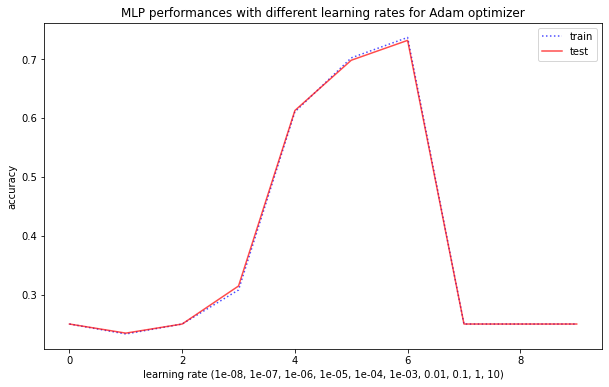

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(train_accs_adam, label="train", color="blue", alpha=0.7, linestyle=":")
plt.plot(test_accs_adam, label="test", color="red", alpha=0.7)
plt.legend()
plt.xlabel("learning rate (1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 1, 10)")
plt.ylabel("accuracy")
plt.title("MLP performances with different learning rates for Adam optimizer")
plt.show()

### $\textbf{Learning rate impact on SGD}$

In [ ]:
train_accs_sgd = []
test_accs_sgd = []

for lr in learning_rates:
  mlp_tmp = mlp(optimizer="SGD", lr=lr)
  mlp_tmp.fit(X_train, y_ohe_train, epochs=10)
  train_acc = accuracy_score(y_train_, np.argmax(mlp_tmp.predict(X_train), axis=1))
  test_acc = accuracy_score(y_test_, np.argmax(mlp_tmp.predict(X_test), axis=1))
  train_accs_sgd.append(train_acc)
  test_accs_sgd.append(test_acc)

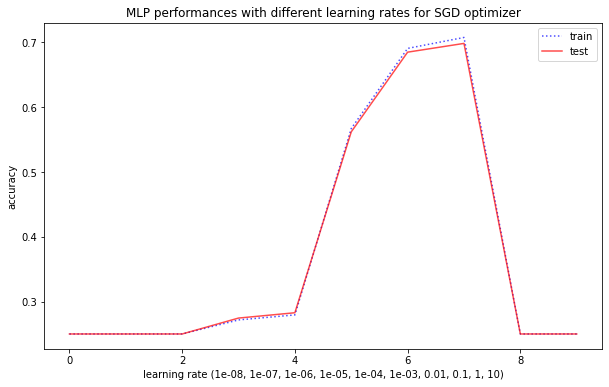

In [136]:
plt.figure(figsize=(10,6))
plt.plot(train_accs_sgd, label="train", color="blue", alpha=0.7, linestyle=":")
plt.plot(test_accs_sgd, label="test", color="red", alpha=0.7)
plt.legend()
plt.xlabel("learning rate (1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 1, 10)")
plt.ylabel("accuracy")
plt.title("MLP performances with different learning rates for SGD optimizer")
plt.show()

### $\textbf{Learning rate impact on Adagrad}$

In [ ]:
train_accs_adagrad = []
test_accs_adagrad = []

for lr in learning_rates:
  mlp_tmp = mlp(optimizer="Adagrad", lr=lr)
  mlp_tmp.fit(X_train, y_ohe_train, epochs=10)
  train_acc = accuracy_score(y_train_, np.argmax(mlp_tmp.predict(X_train), axis=1))
  test_acc = accuracy_score(y_test_, np.argmax(mlp_tmp.predict(X_test), axis=1))
  train_accs_adagrad.append(train_acc)
  test_accs_adagrad.append(test_acc)

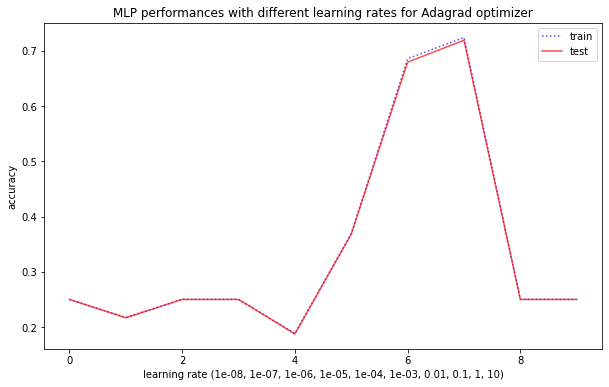

In [138]:
plt.figure(figsize=(10,6))
plt.plot(train_accs_adagrad, label="train", color="blue", alpha=0.7, linestyle=":")
plt.plot(test_accs_adagrad, label="test", color="red", alpha=0.7)
plt.legend()
plt.xlabel("learning rate (1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 1, 10)")
plt.ylabel("accuracy")
plt.title("MLP performances with different learning rates for Adagrad optimizer")
plt.show()

### $\textbf{Learning rate impact on Adamax}$

In [143]:
train_accs_adamax = []
test_accs_adamax = []

for lr in learning_rates:
  mlp_tmp = mlp(optimizer="Adamax", lr=lr)
  mlp_tmp.fit(X_train, y_ohe_train, epochs=10)
  train_acc = accuracy_score(y_train_, np.argmax(mlp_tmp.predict(X_train), axis=1))
  test_acc = accuracy_score(y_test_, np.argmax(mlp_tmp.predict(X_test), axis=1))
  train_accs_adamax.append(train_acc)
  test_accs_adamax.append(test_acc)

Epoch 1/10
1256/1256 [==============================] - 4s 3ms/step - loss: 1.5603 - accuracy: 0.2536
Epoch 2/10
1256/1256 [==============================] - 2s 2ms/step - loss: 1.5603 - accuracy: 0.2536
Epoch 3/10
1256/1256 [==============================] - 2s 2ms/step - loss: 1.5603 - accuracy: 0.2536
Epoch 4/10
1256/1256 [==============================] - 2s 2ms/step - loss: 1.5603 - accuracy: 0.2536
Epoch 5/10
1256/1256 [==============================] - 2s 2ms/step - loss: 1.5602 - accuracy: 0.2536
Epoch 6/10
1256/1256 [==============================] - 2s 2ms/step - loss: 1.5602 - accuracy: 0.2536
Epoch 7/10
1256/1256 [==============================] - 2s 2ms/step - loss: 1.5602 - accuracy: 0.2536
Epoch 8/10
1256/1256 [==============================] - 2s 2ms/step - loss: 1.5602 - accuracy: 0.2536
Epoch 9/10
1256/1256 [==============================] - 2s 2ms/step - loss: 1.5602 - accuracy: 0.2536
Epoch 10/10
1256/1256 [==============================] - 2s 2ms/step - loss: 1.560

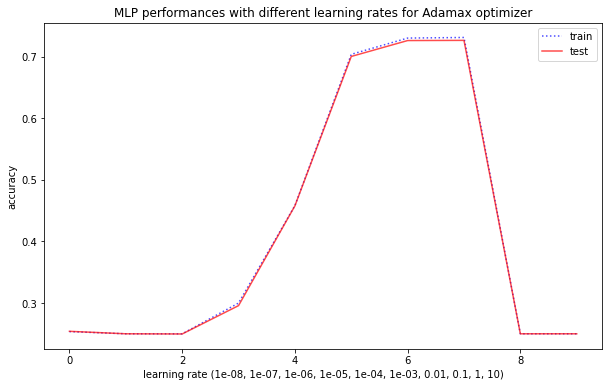

In [144]:
plt.figure(figsize=(10,6))
plt.plot(train_accs_adamax, label="train", color="blue", alpha=0.7, linestyle=":")
plt.plot(test_accs_adamax, label="test", color="red", alpha=0.7)
plt.legend()
plt.xlabel("learning rate (1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 1, 10)")
plt.ylabel("accuracy")
plt.title("MLP performances with different learning rates for Adamax optimizer")
plt.show()

### $\textbf{Find the best optimizer}$



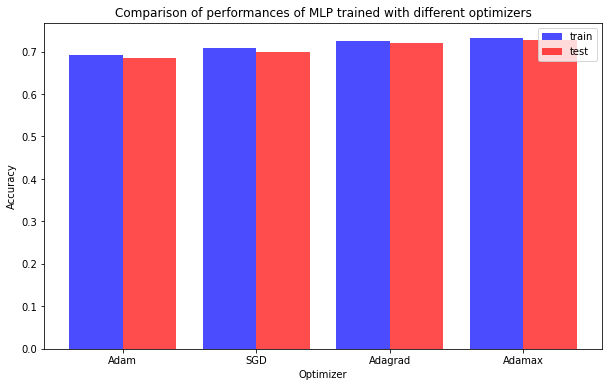

In [145]:
import numpy as np 
import matplotlib.pyplot as plt 

X = ['Adam','SGD','Adagrad', 'Adamax']

args = [np.argmax(test_accs_adam), np.argmax(test_accs_sgd), np.argmax(test_accs_adagrad), np.argmax(test_accs_adamax)]
train_accs = [train_accs_sgd[args[0]], train_accs_sgd[args[1]], train_accs_adagrad[args[2]], train_accs_adamax[args[3]]]
test_accs = [test_accs_sgd[args[0]], test_accs_sgd[args[1]], test_accs_adagrad[args[2]], test_accs_adamax[args[3]]]
  
X_axis = np.arange(len(X))

plt.figure(figsize=(10,6))
plt.bar(X_axis - 0.2, train_accs, 0.4, label = 'train', color="blue", alpha=0.7)
plt.bar(X_axis + 0.2, test_accs, 0.4, label = 'test', color="red", alpha=0.7)
  
plt.xticks(X_axis, X)
plt.xlabel("Optimizer")
plt.ylabel("Accuracy")
plt.title("Comparison of performances of MLP trained with different optimizers")
plt.legend()
plt.show()

In [146]:
args

[6, 7, 7, 7]

In [150]:
learning_rates[7]

0.1

In [148]:
test_accs_adamax[7]

0.7267841146610928

In [152]:
mlp_best = mlp(optimizer="Adamax", lr=learning_rates[7])
mlp_best.fit(X_train, y_ohe_train, epochs=10)

Epoch 1/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.7705 - accuracy: 0.6602
Epoch 2/10
1256/1256 [==============================] - 2s 2ms/step - loss: 0.7094 - accuracy: 0.7063
Epoch 3/10
1256/1256 [==============================] - 2s 2ms/step - loss: 0.7002 - accuracy: 0.7069
Epoch 4/10
1256/1256 [==============================] - 2s 2ms/step - loss: 0.6922 - accuracy: 0.7121
Epoch 5/10
1256/1256 [==============================] - 2s 2ms/step - loss: 0.6869 - accuracy: 0.7146
Epoch 6/10
1256/1256 [==============================] - 2s 2ms/step - loss: 0.6823 - accuracy: 0.7174
Epoch 7/10
1256/1256 [==============================] - 2s 2ms/step - loss: 0.6818 - accuracy: 0.7135
Epoch 8/10
1256/1256 [==============================] - 2s 2ms/step - loss: 0.6763 - accuracy: 0.7173
Epoch 9/10
1256/1256 [==============================] - 2s 2ms/step - loss: 0.6710 - accuracy: 0.7190
Epoch 10/10
1256/1256 [==============================] - 2s 2ms/step - loss: 0.668

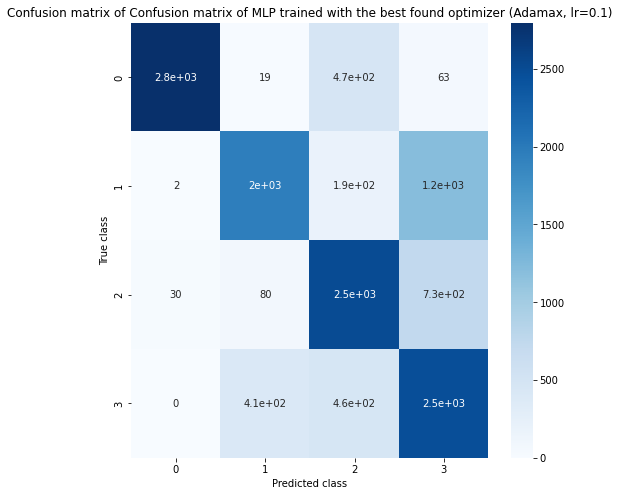

In [153]:
def plot_confusion_matrix(model, X_test, y_test, model_name=""):
  from sklearn.metrics import confusion_matrix
  import matplotlib.pyplot as plt
  import seaborn as sns

  preds = np.argmax(model.predict(X_test), axis=1) # adapt to softmax
  conf_mat = confusion_matrix(y_test, preds)
  plt.figure(figsize=(8,8))
  sns.heatmap(conf_mat, cmap="Blues",
  annot=True,
  )
  plt.title("Confusion matrix of {}".format(model_name))
  plt.xlabel("Predicted class")
  plt.ylabel("True class")
  plt.show()

plot_confusion_matrix(mlp_best, X_test, y_test=y_test_, model_name="Confusion matrix of MLP trained with the best found optimizer (Adamax, lr=0.1)")